# VGG Implementation

### Importing Libraries

In [3]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Grayscale
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchsummary
from tqdm import tqdm

### Data Augmentation

Defineing two image preprocessing pipelines using PyTorch’s transforms. Compose—one for training and one for validation/testing. The train_transforms pipeline includes resizing to 224×224 pixels, followed by data augmentation techniques like random horizontal and vertical flips, random rotation, and brightness/contrast jittering to improve model robustness and prevent overfitting. It then converts images to tensors and normalizes them using ImageNet’s mean and standard deviation values. The val_test_transforms pipeline is simpler, applying only resizing, tensor conversion, and normalization to ensure consistent input formatting without altering image content during evaluation.

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        
    transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(20),        
    transforms.RandomVerticalFlip(),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),                
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Loading the dataset

In [5]:
dataset_path = "AlzheimerDataset"

train_data = ImageFolder(root=dataset_path, transform=train_transforms)
val_data = ImageFolder(root=dataset_path, transform=val_test_transforms)
test_data = ImageFolder(root=dataset_path, transform=val_test_transforms)
print(f"Classes: {train_data.classes}")
print(f"Class-to-Index Mapping: {train_data.class_to_idx}")

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Class-to-Index Mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [6]:
batch_size = 8

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Number of images per class

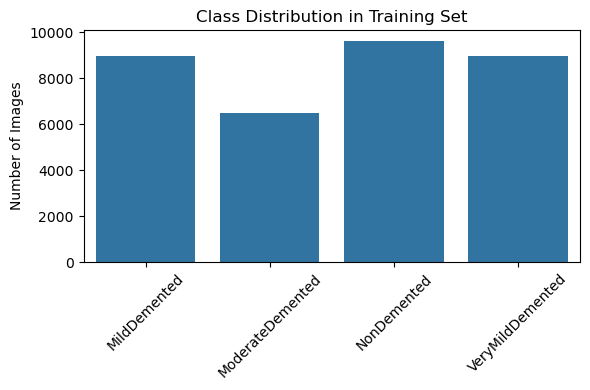

In [7]:
class_counts = Counter([label for _, label in train_data.imgs])
labels = [train_data.classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize = (6, 4))
sns.barplot(x = labels, y = counts)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Training data summary

Statistics

In [8]:
image_shapes = []
for path, _ in train_data.imgs:
    with Image.open(path) as img:
        image_shapes.append(img.size)

shape_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print(shape_df.describe())

              Width        Height
count  33984.000000  33984.000000
mean     196.233522    188.116761
std        7.819527      3.909764
min      180.000000    180.000000
25%      200.000000    190.000000
50%      200.000000    190.000000
75%      200.000000    190.000000
max      200.000000    190.000000


### Random images from the dataset with class names

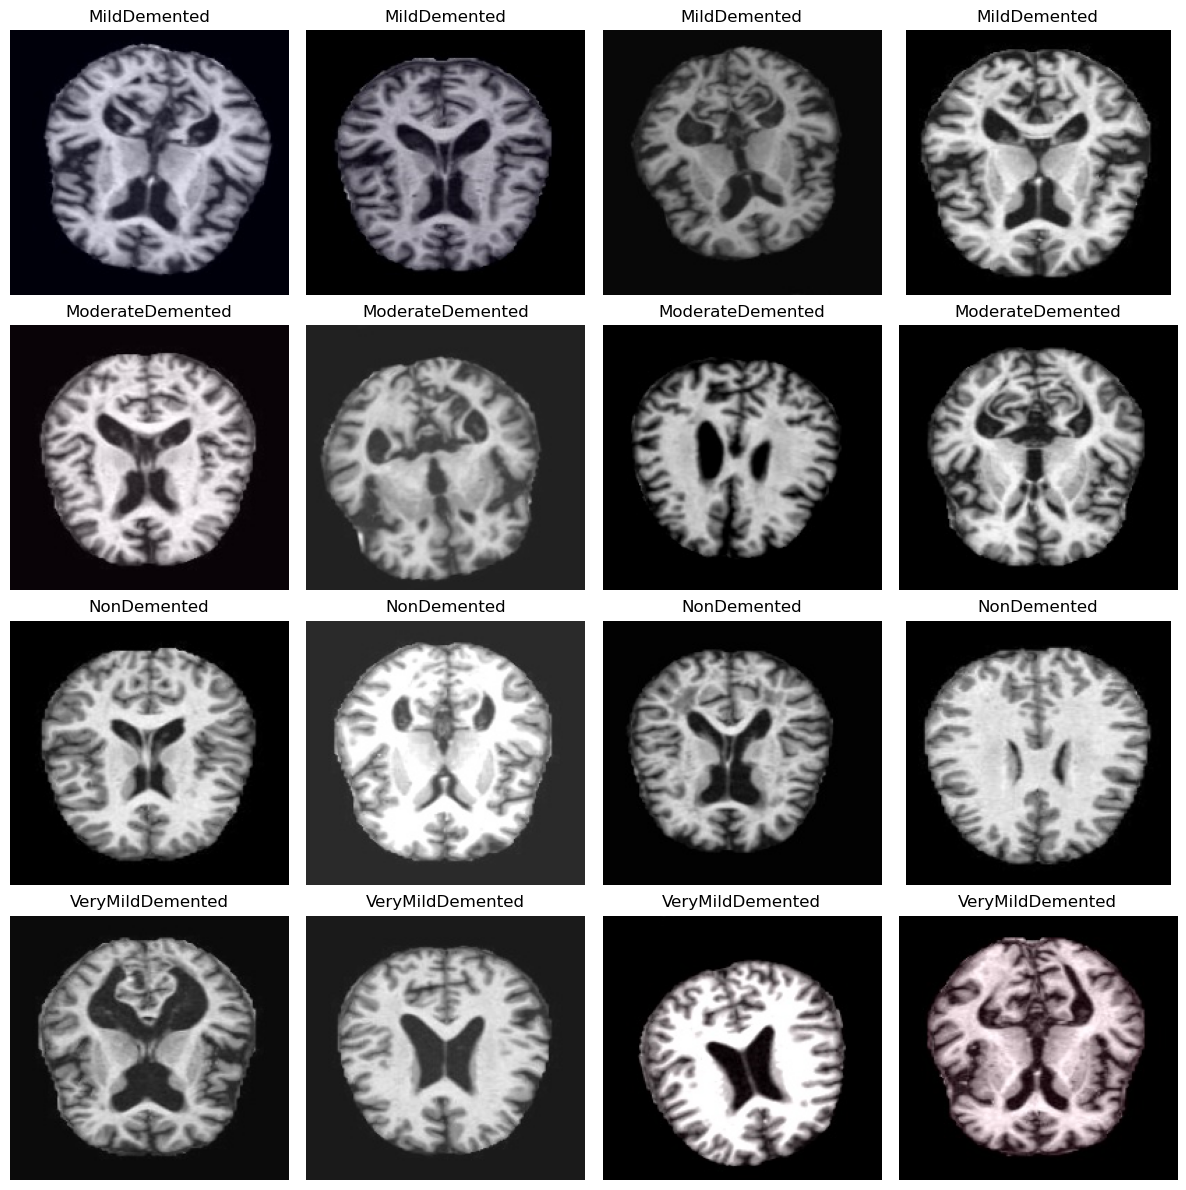

In [9]:
def show_images_by_class(dataset, class_names, samples_per_class=4):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class * 3, len(class_names) * 3))
    for i, class_name in enumerate(class_names):
        class_idx = dataset.class_to_idx[class_name]
        indices = [j for j, (_, label) in enumerate(dataset.imgs) if label == class_idx]
        sampled_indices = random.sample(indices, samples_per_class)
        for k, idx in enumerate(sampled_indices):
            img_path, _ = dataset.imgs[idx]
            image = Image.open(img_path)
            axes[i, k].imshow(image)
            axes[i, k].set_title(class_name)
            axes[i, k].axis("off")
    plt.tight_layout()
    plt.show()

show_images_by_class(train_data, train_data.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02352938..1.0137256].


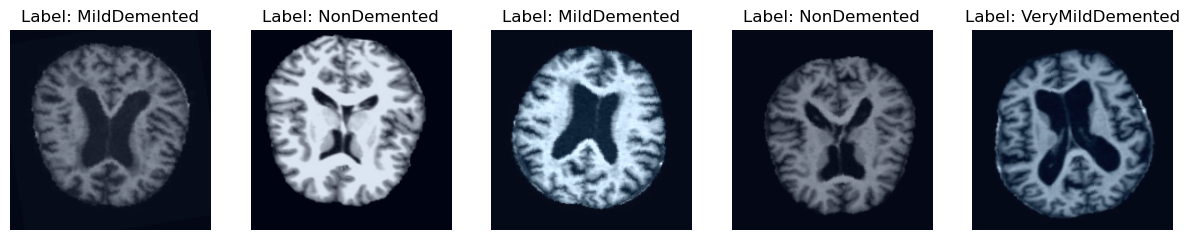

In [10]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))
    image = image * 0.229 + 0.485
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {train_data.classes[labels[i]]}")
    axes[i].axis("off")

plt.show()

### Balancing classes using weighted sampling

Handling class imbalance in the training dataset by applying weighted random sampling. It first counts the number of samples in each class using Counter, then computes class weights inversely proportional to their frequencies—giving higher weights to underrepresented classes. Each training sample is then assigned a corresponding weight. A WeightedRandomSampler is used to sample data such that all classes are represented more evenly during training. This sampler is passed to a DataLoader to ensure balanced batches. Finally, a message confirms that class balancing has been successfully applied.

In [11]:
class_counts = Counter(train_data.targets)
total_count = sum(class_counts.values())
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_data.targets]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=2)

print("Class balancing using weighted sampling is applied!")

Class balancing using weighted sampling is applied!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764705..1.0576298].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.0696037].


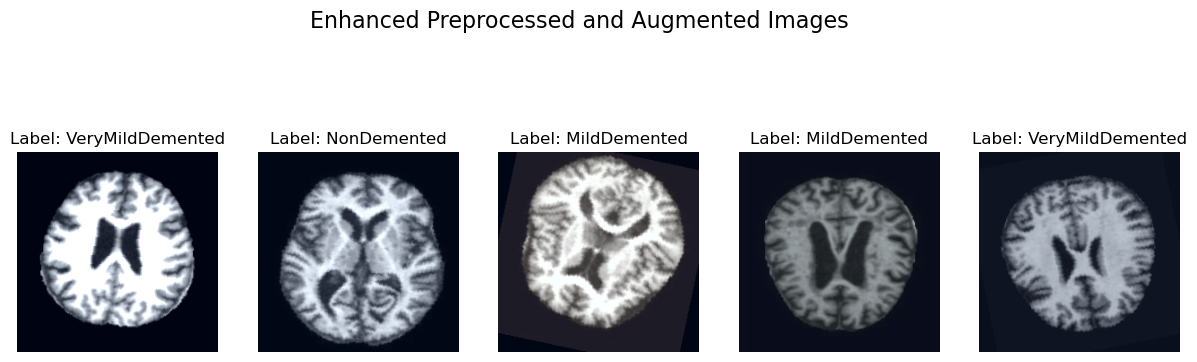

In [12]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))
    image = image * 0.229 + 0.485  
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {train_data.classes[labels[i]]}")
    axes[i].axis("off")

plt.suptitle("Enhanced Preprocessed and Augmented Images", fontsize=16)
plt.show()

In [13]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch Size: {images.size(0)}")
print(f"Image Shape: {images.shape}")
print(f"Image Mean: {images.mean().item():.4f}, Image Std: {images.std().item():.4f}")


Batch Size: 8
Image Shape: torch.Size([8, 3, 224, 224])
Image Mean: -0.7210, Image Std: 1.5015


### Defining VGG model

In [14]:
import torch
import torch.nn as nn

class VGG16_Model_Modified(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16_Model_Modified, self).__init__()

        
        self.features = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),  
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),  
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512), 
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),  
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 

           
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),  
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),  
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
        )

        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024, bias=False),  
            nn.BatchNorm1d(1024),  
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),  
        )

    def forward(self, x):
        
        x = self.features(x)
        x = torch.flatten(x, 1)  
       
        x = self.classifier(x)
        return x


model = VGG16_Model_Modified(num_classes=4)
print(model)


VGG16_Model_Modified(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, 

### Training the model

Using device: mps


Epoch 1/10 [Val]: 100%|█████████████████████| 4248/4248 [13:43<00:00,  5.16it/s]



Epoch 1/10
Train Loss: 1.3246 | Train Acc: 0.3697
Val Loss: 1.0603 | Val Acc: 0.4883
Saved best model with Val Acc: 0.4883


Epoch 2/10 [Val]: 100%|█████████████████████| 4248/4248 [12:30<00:00,  5.66it/s]



Epoch 2/10
Train Loss: 1.0763 | Train Acc: 0.5117
Val Loss: 1.6143 | Val Acc: 0.3592


Epoch 3/10 [Val]: 100%|█████████████████████| 4248/4248 [12:38<00:00,  5.60it/s]



Epoch 3/10
Train Loss: 0.9049 | Train Acc: 0.5880
Val Loss: 0.7443 | Val Acc: 0.6547
Saved best model with Val Acc: 0.6547


Epoch 4/10 [Val]: 100%|█████████████████████| 4248/4248 [11:10<00:00,  6.33it/s]



Epoch 4/10
Train Loss: 0.8291 | Train Acc: 0.6218
Val Loss: 0.7367 | Val Acc: 0.6589
Saved best model with Val Acc: 0.6589


Epoch 5/10 [Val]: 100%|█████████████████████| 4248/4248 [11:43<00:00,  6.04it/s]



Epoch 5/10
Train Loss: 0.7611 | Train Acc: 0.6505
Val Loss: 0.6565 | Val Acc: 0.6934
Saved best model with Val Acc: 0.6934


Epoch 6/10 [Val]: 100%|█████████████████████| 4248/4248 [11:38<00:00,  6.08it/s]



Epoch 6/10
Train Loss: 0.7263 | Train Acc: 0.6658
Val Loss: 0.6503 | Val Acc: 0.7031
Saved best model with Val Acc: 0.7031


Epoch 7/10 [Val]: 100%|█████████████████████| 4248/4248 [17:33<00:00,  4.03it/s]



Epoch 7/10
Train Loss: 0.6810 | Train Acc: 0.6943
Val Loss: 0.6048 | Val Acc: 0.7259
Saved best model with Val Acc: 0.7259


Epoch 8/10 [Val]: 100%|█████████████████████| 4248/4248 [12:55<00:00,  5.48it/s]



Epoch 8/10
Train Loss: 0.6433 | Train Acc: 0.7105
Val Loss: 0.5693 | Val Acc: 0.7445
Saved best model with Val Acc: 0.7445


Epoch 9/10 [Val]: 100%|█████████████████████| 4248/4248 [11:39<00:00,  6.08it/s]



Epoch 9/10
Train Loss: 0.6117 | Train Acc: 0.7240
Val Loss: 0.5494 | Val Acc: 0.7559
Saved best model with Val Acc: 0.7559


Epoch 10/10 [Val]: 100%|████████████████████| 4248/4248 [11:35<00:00,  6.11it/s]



Epoch 10/10
Train Loss: 0.5904 | Train Acc: 0.7332
Val Loss: 0.5013 | Val Acc: 0.7836
Saved best model with Val Acc: 0.7836


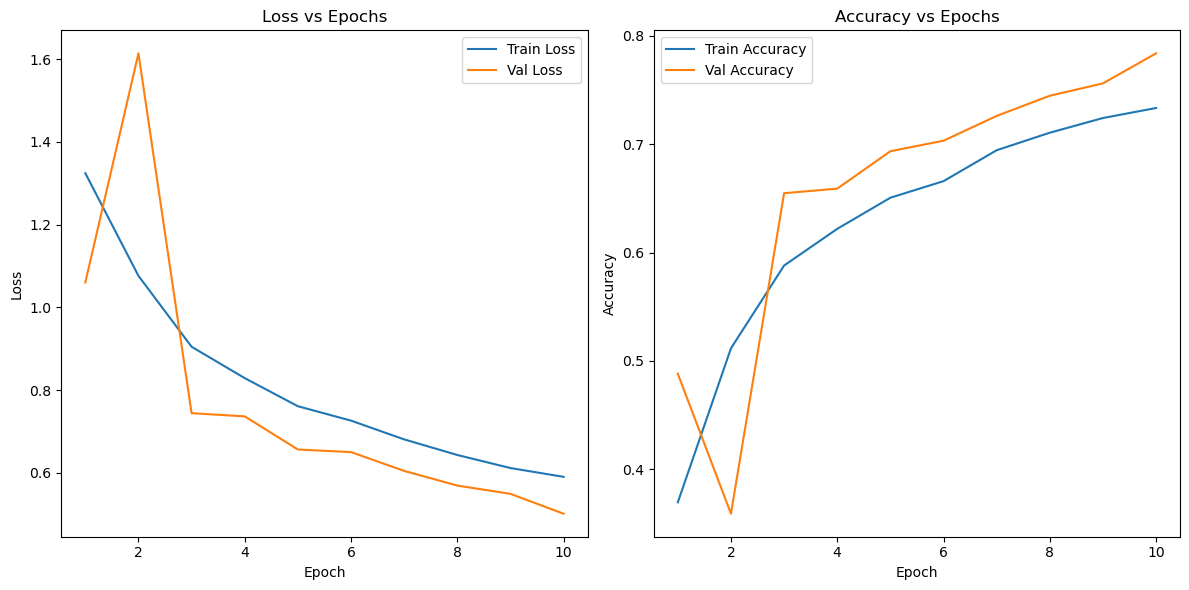

In [15]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)  


def train_model(model, train_loader, val_loader, epochs):
    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    best_val_acc = 0.0  

    for epoch in range(epochs):
        model.train()  
        running_loss = 0.0
        running_corrects = 0

        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)  

            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            _, preds = torch.max(outputs, 1)  

            loss.backward()  
            optimizer.step()  

            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)  
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        
        model.eval()  
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():  
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)  
                outputs = model(inputs)  
                loss = criterion(outputs, labels)  
                _, preds = torch.max(outputs, 1)  

                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.float() / len(val_loader.dataset)  
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_dense.pt")  
            print(f"Saved best model with Val Acc: {best_val_acc:.4f}")

   
    plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies)


def plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Val Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()


    plt.tight_layout()
    plt.show()


train_model(model, train_loader, val_loader, epochs=10)


### Training/Validation Loss and Accuracy curves

### Random predictions made by the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.8731157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


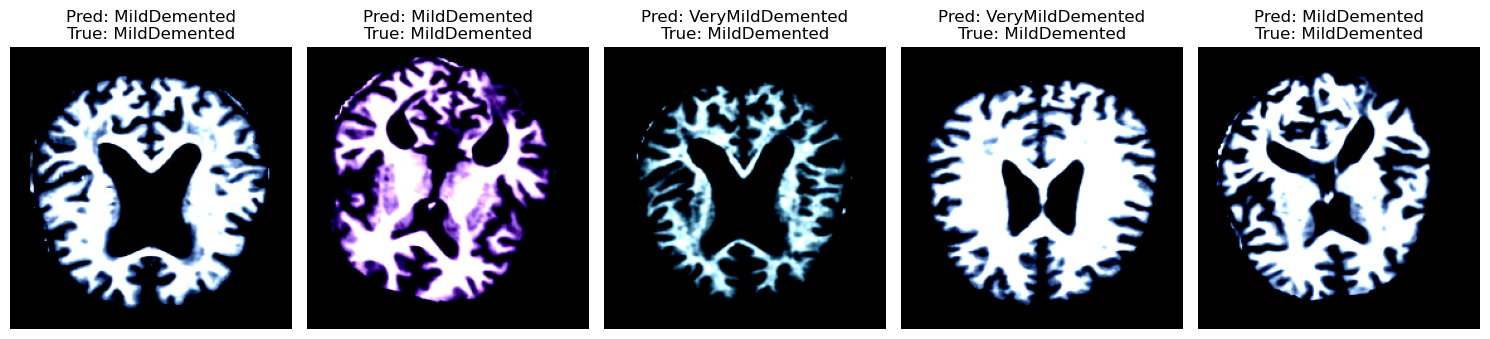

In [25]:
import random
import torch
import matplotlib.pyplot as plt

def visualize_random_predictions(model, data_loader, class_names, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    
    assert len(labels) == len(images)

    indices = random.sample(range(len(images)), num_images)  

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for idx, ax in zip(indices, axes):
        img = images[idx].cpu().numpy().transpose(1, 2, 0)  
        ax.imshow(img)
        output = model(images[idx].unsqueeze(0))  
        pred = torch.max(output, 1)[1]  

        ax.set_title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[labels[idx].item()]}", fontsize=12)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']  
visualize_random_predictions(model, val_loader, class_names)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.0539435].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


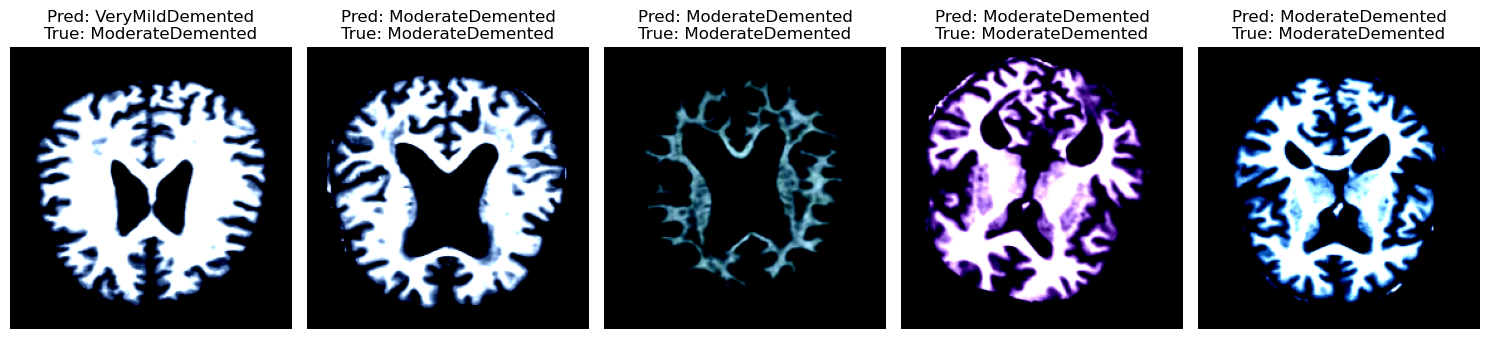

In [28]:
import random
import torch
import matplotlib.pyplot as plt

def visualize_random_predictions(model, data_loader, class_names, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    
    assert len(labels) == len(images)

    indices = random.sample(range(len(images)), num_images)  

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for idx, ax in zip(indices, axes):
        img = images[idx].cpu().numpy().transpose(1, 2, 0)  
        ax.imshow(img)
        output = model(images[idx].unsqueeze(0))  
        pred = torch.max(output, 1)[1]  

        ax.set_title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[labels[idx].item()]}", fontsize=12)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

class_names = [ 'ModerateDemented','MildDemented','NonDemented', 'VeryMildDemented']  
visualize_random_predictions(model, val_loader, class_names)


### Testing the model

Testing: 100%|██████████████████████████████| 4248/4248 [09:26<00:00,  7.49it/s]


Test Accuracy: 0.7836

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.86      0.81      0.83      8960
ModerateDemented       0.99      1.00      1.00      6464
     NonDemented       0.86      0.59      0.70      9600
VeryMildDemented       0.58      0.81      0.68      8960

        accuracy                           0.78     33984
       macro avg       0.82      0.80      0.80     33984
    weighted avg       0.81      0.78      0.79     33984



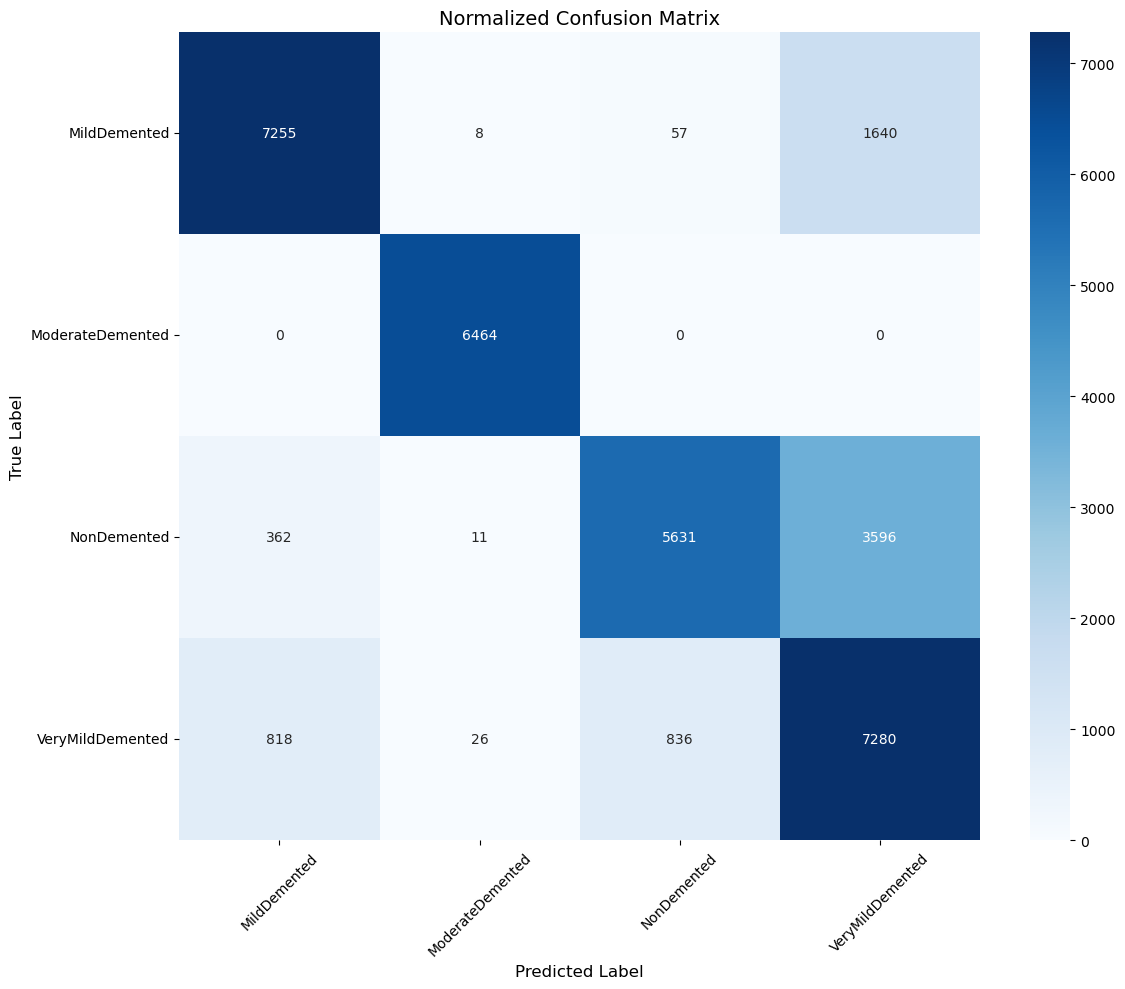

In [20]:
def test_model(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred, target_names=class_names)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{clf_report}")
    
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=class_names,  yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy

test_accuracy = test_model(model = model, test_loader = test_loader, device = device, class_names = test_data.classes)